<a href="https://colab.research.google.com/github/snicolau/HumanBodyOcclusionMaskEstimation/blob/main/04_3D_BodyReconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3D Body Reconstruction

Based on https://colab.research.google.com/github/sergeyprokudin/smplpix/blob/main/colab_notebooks/Convert_Video_to_SMPLpix_Dataset.ipynb



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import matplotlib.pyplot as plt
from pylab import imshow, imsave
!pip install iglovikov_helper_functions
from iglovikov_helper_functions.utils.image_utils import load_rgb, pad, unpad
from iglovikov_helper_functions.dl.pytorch.utils import tensor_from_rgb_image

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = load_rgb(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [ ]:
!mkdir '/content/movies/'
!cp -av '/content/drive/MyDrive/IR/frames' '/content/movies/'
!mv '/content/movies/frames' '/content/movies/images'

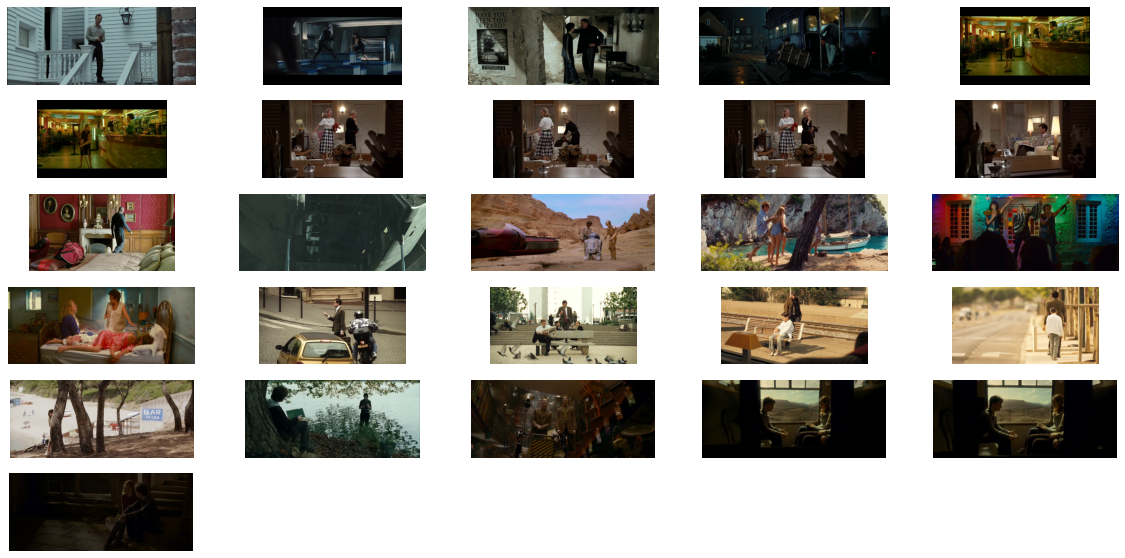

In [ ]:
folder = '/content/drive/MyDrive/IR/frames'
images = load_images_from_folder(folder)

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')

## 1. Obtain 3D pose with Openpose

#### Openpose

In [ ]:
import os
from os.path import exists, join, basename, splitext


git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
  !pip install -q youtube-dl
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`
  
from IPython.display import YouTubeVideo

In [ ]:
%cd '/content/'
!rm -rf '/content/movies/keypoints/'
!cd openpose && ./build/examples/openpose/openpose.bin --image_dir /content/movies/images --write_json /content/movies/keypoints/ --display 0 --write_images /content/openpose_images --face --hand

/content
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 43.327140 seconds.


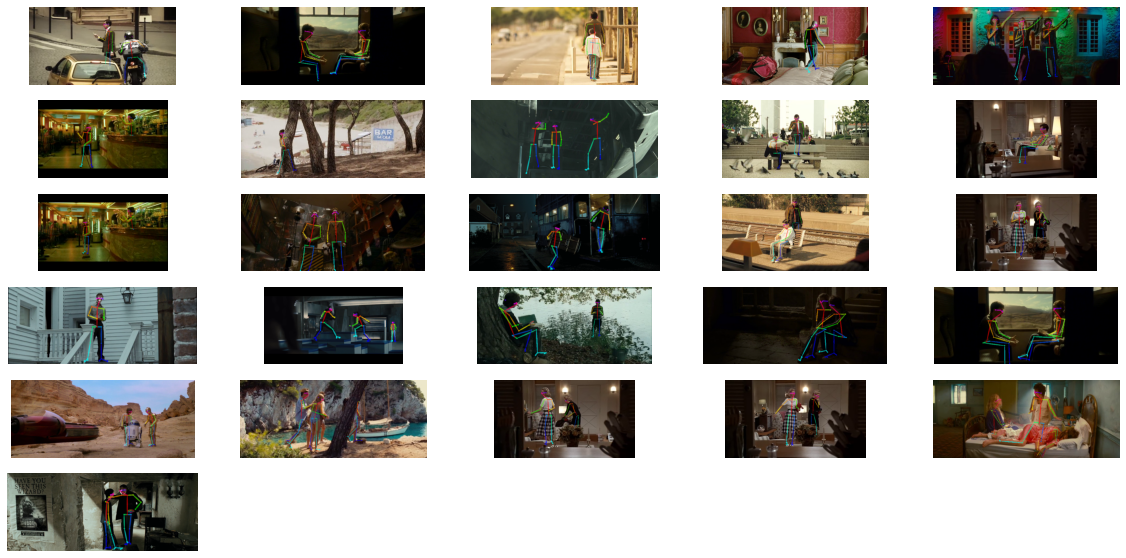

In [ ]:
openpose_images = load_images_from_folder('openpose_images')

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(openpose_images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')

## 2. Obtain 3D model with simplify-X

In [ ]:
# @title Install SMPLify-X and other dependencies

%cd /content
!pip install chumpy
!pip install smplx
!git clone https://github.com/vchoutas/smplx
%cd smplx
!python setup.py install

#vposer
!pip install git+https://github.com/nghorbani/configer
!pip install git+https://github.com/sergeyprokudin/human_body_prior

!pip install torch==1.1.0
%cd /content
!git clone https://github.com/sergeyprokudin/smplify-x
%cd /content/smplify-x
!pip install -r requirements.txt

In [ ]:
SMPLX_ZIP_PATH = '/content/drive/MyDrive/datasets/models_smplx_v1_1.zip' # @param {type:"string"}
VPOSER_ZIP_PATH = '/content/drive/MyDrive/datasets/vposer_v1_0.zip' # @param {type:"string"}

SMPLX_MODEL_PATH = '/content/smplx'
!mkdir $SMPLX_MODEL_PATH
!unzip -n '$SMPLX_ZIP_PATH' -d  $SMPLX_MODEL_PATH
VPOSER_MODEL_PATH = '/content/vposer'
!mkdir $VPOSER_MODEL_PATH
!unzip -n '$VPOSER_ZIP_PATH' -d  $VPOSER_MODEL_PATH

In [ ]:
!cp -av '/content/keypoints' '/content/movies/'

In [ ]:
%cd /content/
!unzip movies.zip

Make it transparent: edit simplifyx file

In [ ]:
!rm -rf '/content/movies/results'
#!rm -rf '/content/smplx'
#!rm -rf '/content/vposer'

In [ ]:
gender = 'neutral' # ["neutral", "female", "male"]

!rm -rf /content/data/smplifyx_results
%cd /content/smplify-x
!git pull origin
!python3 smplifyx/main.py --config cfg_files/fit_smplx.yaml \
    --data_folder  /content/movies \
    --output_folder /content/movies/results \
    --visualize=True \
    --gender=$gender \
    --model_folder /content/smplx/models \
    --vposer_ckpt /content/vposer/vposer_v1_0 \
    --part_segm_fn smplx_parts_segm.pkl 

In [ ]:
!zip -r /content/movies.zip /content/movies/ 

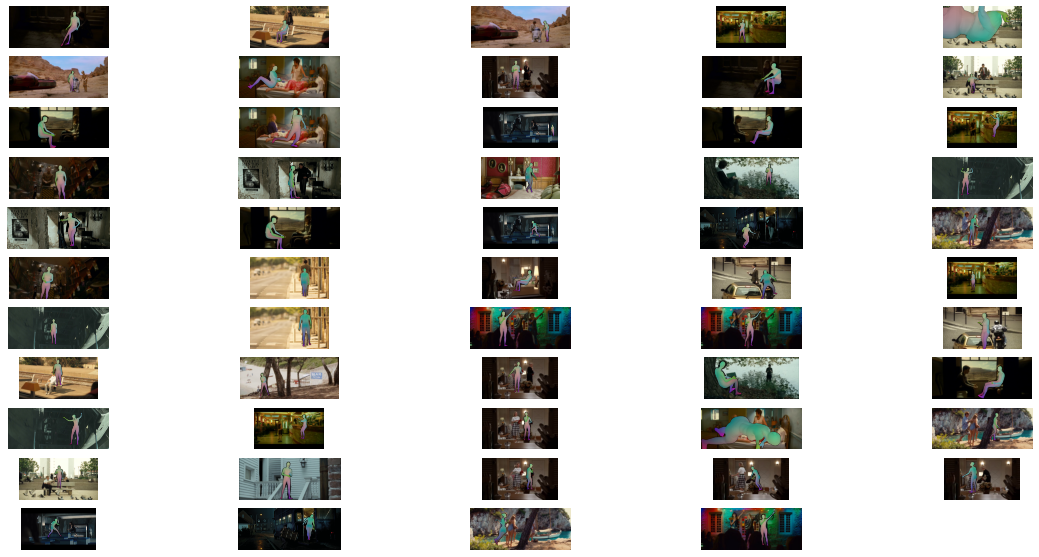

In [ ]:
simplx_images = load_images_from_folder('/content/movies/results/rendered_smplifyx_meshes')
meshes = '/content/movies/results/meshes'
images = load_images_from_folder('/content/movies/images')

plt.figure(figsize=(20,10))
columns = 5
i = 0
for filename in os.listdir('/content/movies/results/input_images'):
    image = cv2.imread(os.path.join('/content/movies/results/rendered_smplifyx_meshes',filename), cv2.IMREAD_UNCHANGED) 
    bckg = load_rgb(os.path.join('/content/movies/results/input_images',filename))
    plt.subplot(len(simplx_images) / columns + 1, columns, i + 1)
    plt.imshow(bckg)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    i = i+1

In [ ]:
def images_the_same(im1, im2):
    """
    :return: True if images are the same, False if images are not the same
    """

    if im1.shape != im2.shape:
        return False

    difference = cv2.subtract(im1, im2)
    b, g, r = cv2.split(difference)

    if cv2.countNonZero(b) == 0 and cv2.countNonZero(g) == 0 and cv2.countNonZero(r) == 0:
        return True
    return False

def in_list(im_list, image):
  for im in im_list:
    if images_the_same(image,im): 
      return True
  return False

def num_list(im_list, image):
  i = 0
  for im in im_list:
    if images_the_same(im, image): 
      return i
    i = i+1
  return -1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


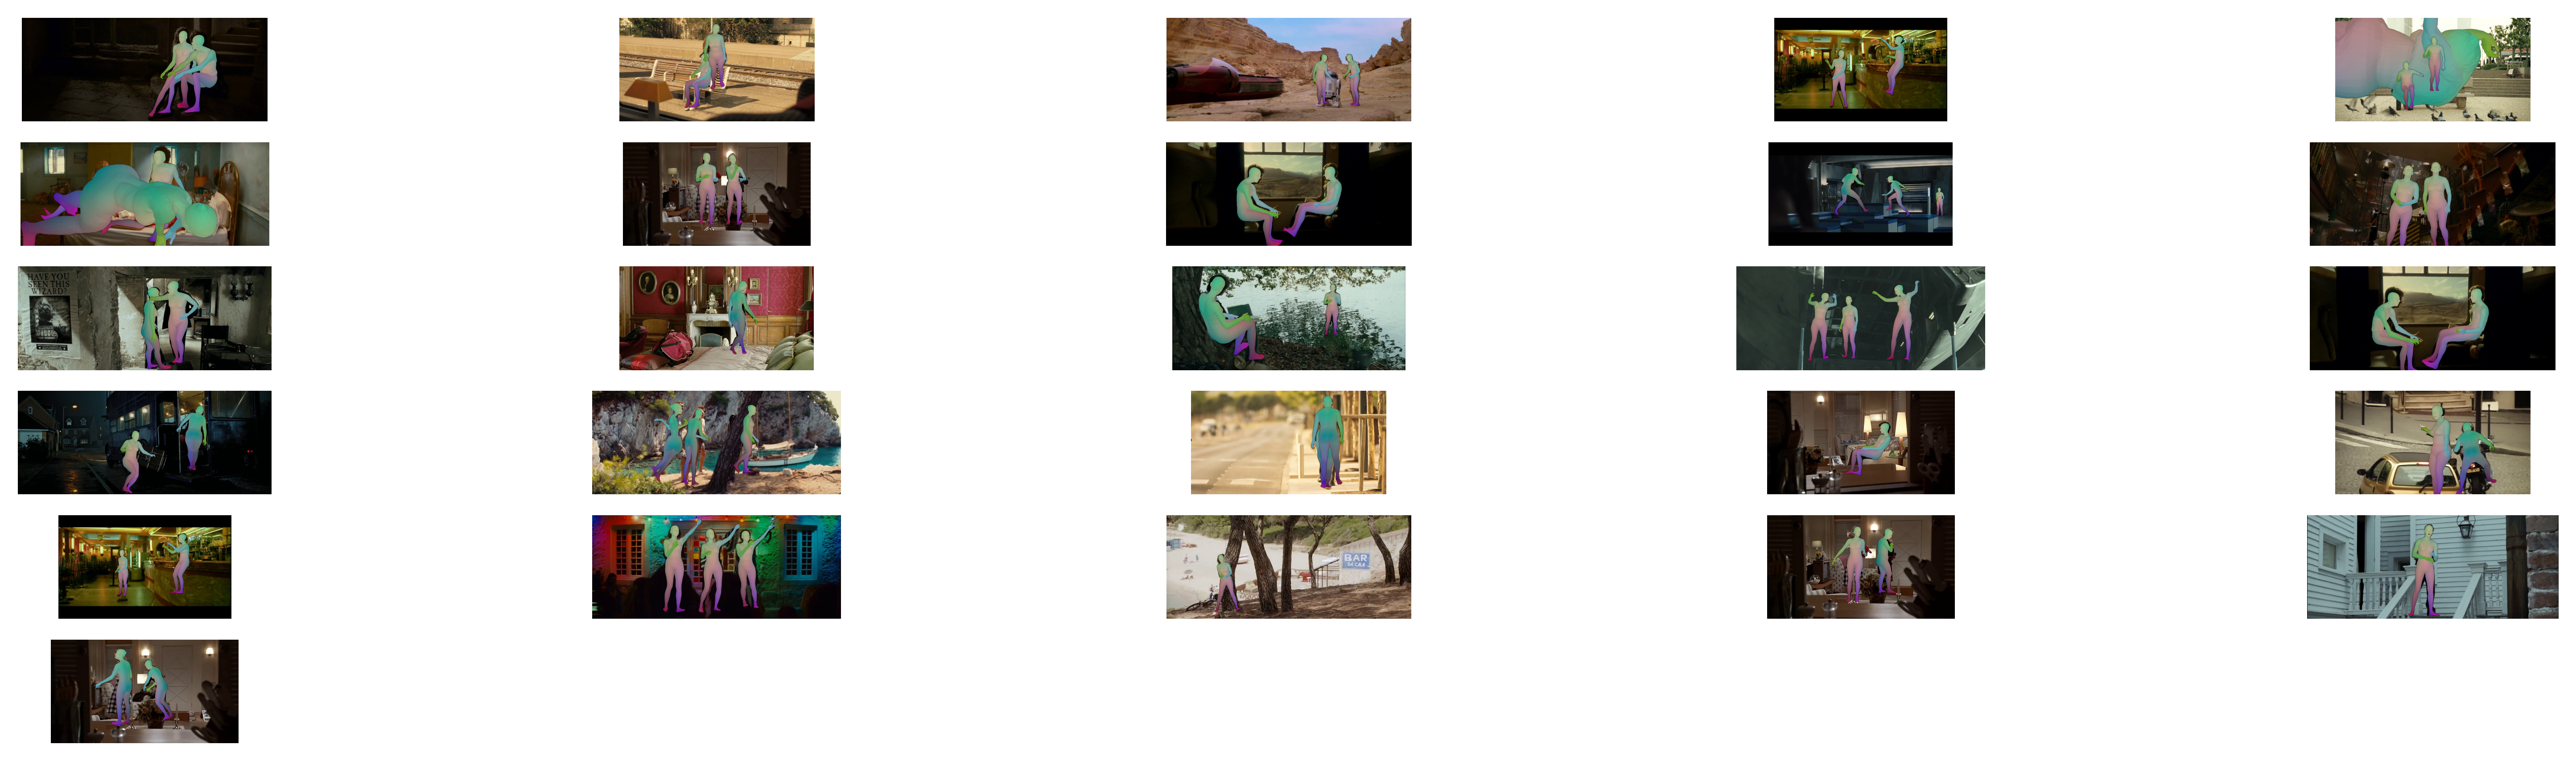

In [ ]:
simplx_images = load_images_from_folder('/content/movies/results/rendered_smplifyx_meshes')
meshes = '/content/movies/results/meshes'
images = load_images_from_folder('/content/movies/images')

plt.figure(figsize=(20,10),dpi=400)
columns = 5
i = 0
bckg_list=[]
for filename in os.listdir('/content/movies/results/input_images'):
    image = cv2.imread(os.path.join('/content/movies/results/rendered_smplifyx_meshes',filename), cv2.IMREAD_UNCHANGED) 
    bckg = load_rgb(os.path.join('/content/movies/results/input_images',filename))
    if not in_list(bckg_list,bckg):
      plt.subplot(len(simplx_images) / columns + 1, columns, i + 1)
      i = i + 1
      plt.imshow(bckg)
      bckg_list.append(bckg)
      plt.imshow(image)
    else:
      ii = num_list(bckg_list,bckg)
      plt.subplot(len(simplx_images) / columns + 1, columns, ii + 1)
      plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')